In [36]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.JiT import JiTUncond_B_8
from collections import OrderedDict
import numpy as np

torch.manual_seed(159753)
np.random.seed(159753)

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn

device = 'cuda:1' 
data = torch.load('data/eit-circles-dataset-128.pt')

train_min = data["train"].min()
train_max = data["train"].max()


gt = data["test"][5].cpu()




cwd = /home/johnma/flow-inverse


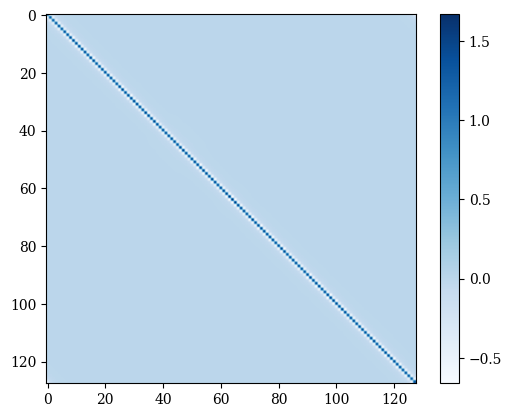

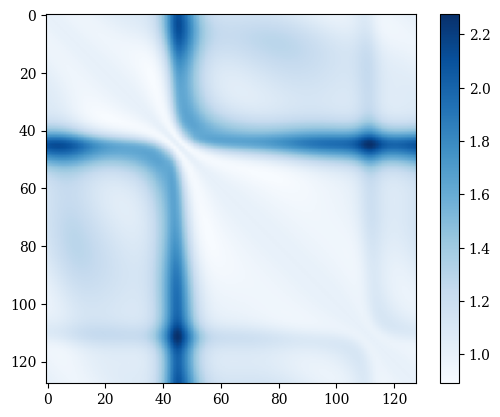

In [37]:
import random 
# load mesh
data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
img_size = 128
original_size = 128
pad_size = 0

gt = data["test"][random.randint(0, len(data["test"]))].cpu()
# gt = data["test"][5].cpu()

mat_fname  = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

# get the dtn map
dtn_map_before = dtn_from_sigma(sigma_vec=gt, v_h=v_h, mesh=mesh, img_size=img_size, device=device)
dtn_background = dtn_from_sigma(sigma_vec=torch.ones(128, 128), v_h=v_h, mesh=mesh, img_size=128, device=device)
dtn_map = dtn_map_before / dtn_background
# dtn_map = torch.log(dtn_map)

plt.imshow(dtn_map_before.reshape((128, 128)).cpu().detach().numpy(), cmap='Blues')
plt.colorbar()


plt.figure()
plt.imshow(dtn_map.reshape((128, 128)).cpu().detach().numpy(), cmap='Blues')
plt.colorbar()


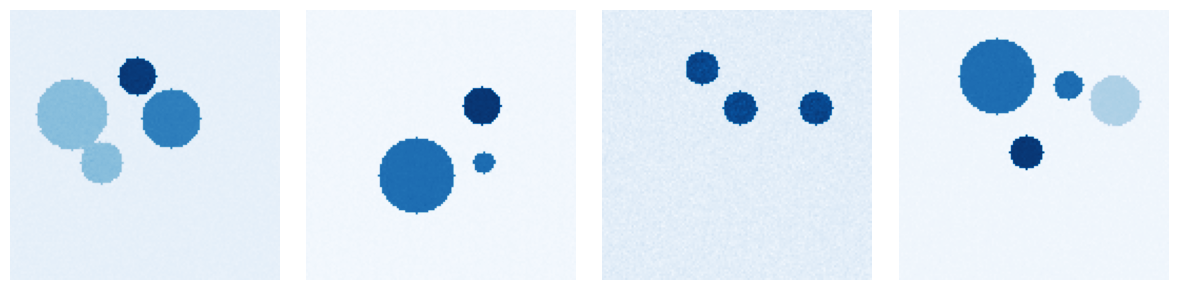

In [38]:
model = JiTUncond_B_8(in_channels=1, input_size=128).to(device)
checkpoint = torch.load("saved_runs/circles-eit-v-pred-jit/checkpoints/ckp_94000.tar", map_location=device)
ema_model = AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(0.999))
ema_model.load_state_dict(checkpoint["ema_state_dict"])  # handles n_averaged + module.* keys
model.load_state_dict(ema_model.module.state_dict())     # now matches JiTUncond_B_8
model.eval()
x0 = torch.randn(4, 1, 128, 128).to(device)

def v_field(z, t):
    t_batch = t.expand(z.shape[0])
    return model(z, t_batch)

timesteps = torch.linspace(0.0, 1.0, steps=20).to(device)
with torch.no_grad():
    pred = odeint(
        func=lambda t, x: v_field(x, t),
        t=timesteps,
        y0=x0,
        method='heun2',
        atol=1e-5,
        rtol=1e-5,
    )[-1]

pred = 0.5 * (pred + 1.0) * (train_max - train_min) + train_min

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    img = pred[i].squeeze().cpu().numpy()
    axes[i].imshow(img, cmap="Blues")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [76]:
import torch
from torch import nn
from torch import optim
from torch.nn import MSELoss
import time

lr = 1e-2
optim_steps = 1000
lbfgs_max_iter = 2
lbfgs_history_size = 10

loss_fn = MSELoss()
x1_trajectory = []
x0_trajectory = []
dtn_trajectory = []

x0 = torch.randn((1, 1, 128, 128), device=device, dtype=torch.float32, requires_grad=True)
y = dtn_map

# optimizer = optim.LBFGS([x0], max_iter=lbfgs_max_iter, lr=lr,
#                         history_size=lbfgs_history_size, line_search_fn='strong_wolfe')
optimizer = optim.Adam([x0], lr=lr, betas=(0.9, 0.99))

cache = {'x1': None, 'measurement': None, 'loss': None}
last_loss = None
start_time = time.time()
pbar = tqdm(range(optim_steps), desc="D-Flow")

for step in pbar:
    def closure():
        optimizer.zero_grad()

        x1 = odeint(
            func=lambda t, x: v_field(x, t),
            t=timesteps,
            y0=x0,
            method='heun2'
        )[-1]

        # unnormalize x1
        x1 = 0.5 * (x1 + 1.0) * (train_max - train_min) + train_min

        measurement = dtn_from_sigma(sigma_vec=x1, v_h=v_h, mesh=mesh,
                                     img_size=img_size, device=device)
        measurement /= dtn_background 

        loss = loss_fn(measurement, y)
        loss.backward()

        cache['x1'] = x1.detach()
        cache['measurement'] = measurement.detach()
        cache['loss'] = loss.detach()

        return loss

    optimizer.step(closure)

    x1_trajectory.append(cache['x1'].cpu().numpy())
    last_loss = cache['loss'].item()
    dtn_trajectory.append(cache['measurement'].cpu().numpy())
    x0_trajectory.append(x0.detach().cpu().numpy())

    grad_norm = x0.grad.norm().item()
    pbar.set_postfix({
        'loss': f'{last_loss:.4f}',
        'grad_norm': f'{grad_norm:.4f}',
    })

print(f"Optimization completed in {time.time() - start_time:.1f} seconds")

D-Flow:   0%|          | 0/1000 [00:00<?, ?it/s]

D-Flow: 100%|██████████| 1000/1000 [10:08<00:00,  1.64it/s, loss=0.0042, grad_norm=0.0060]

Optimization completed in 608.5 seconds


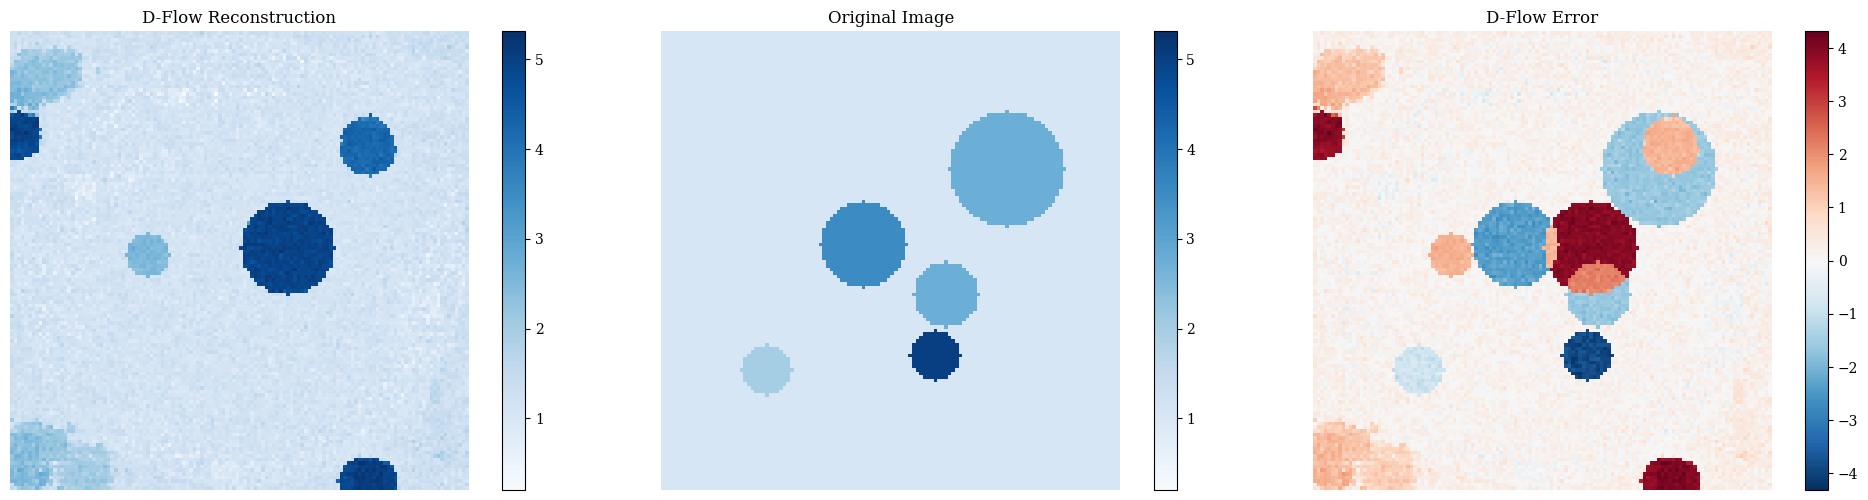

In [77]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

x1 = cache['x1']

warnings.filterwarnings('ignore', category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore')
plt.rcParams["font.family"] = "DejaVu Serif"
title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

vmin = min(x1.squeeze().cpu().numpy().min(), gt.squeeze().cpu().numpy().min())
vmax = max(x1.squeeze().cpu().numpy().max(), gt.squeeze().cpu().numpy().max())

im1 = axes[0].imshow(x1.squeeze().detach().cpu().numpy(), cmap="Blues", vmin=vmin, vmax=vmax)
axes[0].set_title('D-Flow Reconstruction')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

im3 = axes[1].imshow(gt.squeeze().cpu().numpy(), cmap="Blues", vmin=vmin, vmax=vmax)
axes[1].set_title('Original Image')
axes[1].axis('off')
plt.colorbar(im3, ax=axes[1])

error = x1.squeeze().detach().cpu().numpy() - gt.squeeze().cpu().numpy()
im4 = axes[2].imshow(error, cmap='RdBu_r', vmin=-np.abs(error).max(), vmax=np.abs(error).max())
axes[2].set_title('D-Flow Error')
axes[2].axis('off')
plt.colorbar(im4, ax=axes[2])

plt.tight_layout()
plt.show()


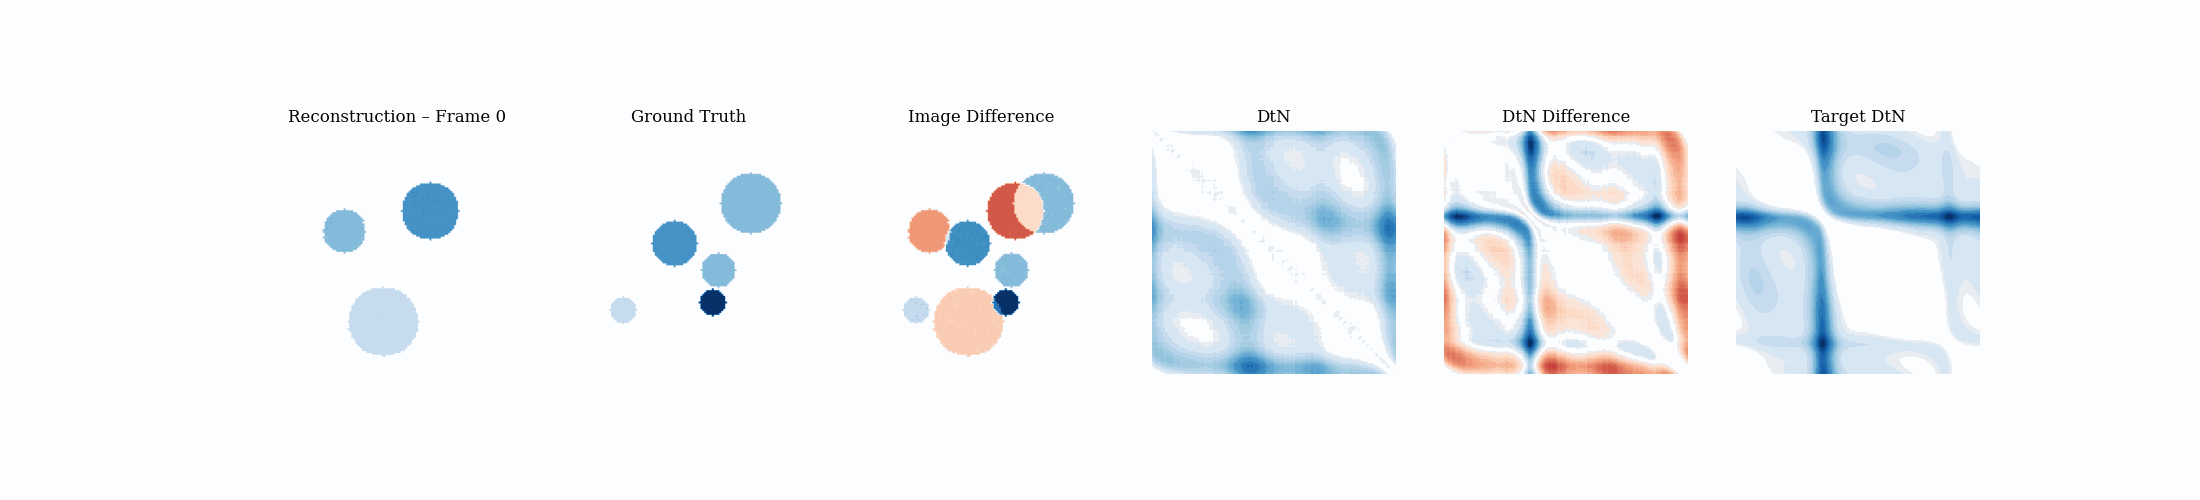

In [79]:
from matplotlib.animation import PillowWriter
import base64, tempfile

import matplotlib.animation as animation
from IPython.display import HTML

SUBSAMPLE = True
SUBSAMPLE_STRIDE = 10

fig, axes = plt.subplots(1, 6, figsize=(22, 5))
ax1, ax2, ax3, ax4, ax5, ax6 = axes

gt_img = gt.squeeze().cpu().numpy()
dtn_gt = dtn_map.squeeze().cpu().numpy()
target_dtn = y.squeeze().cpu().numpy()

num_frames = len(x1_trajectory)
if num_frames == 0:
    raise ValueError("No trajectory samples available for animation.")

if SUBSAMPLE:
    frame_indices = list(range(0, num_frames, SUBSAMPLE_STRIDE))
    if frame_indices[-1] != num_frames - 1:
        frame_indices.append(num_frames - 1)
else:
    frame_indices = list(range(num_frames))

def animate_comparison(frame_idx):
    idx = frame_indices[frame_idx]
    for ax in axes:
        ax.clear()

    current_img = x1_trajectory[idx].squeeze()
    current_dtn = dtn_trajectory[idx].squeeze()

    im1 = ax1.imshow(current_img, cmap="Blues",
                     vmin=gt_img.min(), vmax=gt_img.max())
    ax1.set_title(f"Reconstruction – Frame {idx}", fontsize=12)
    ax1.axis("off")

    im2 = ax2.imshow(gt_img, cmap="Blues",
                     vmin=gt_img.min(), vmax=gt_img.max())
    ax2.set_title("Ground Truth", fontsize=12)
    ax2.axis("off")

    diff_img = current_img - gt_img
    diff_lim = np.abs(diff_img).max() + 1e-12
    im3 = ax3.imshow(diff_img, cmap="RdBu_r",
                     vmin=-diff_lim, vmax=diff_lim)
    ax3.set_title("Image Difference", fontsize=12)
    ax3.axis("off")

    im4 = ax4.imshow(current_dtn, cmap="Blues",
                     vmin=dtn_gt.min(), vmax=dtn_gt.max())
    ax4.set_title("DtN", fontsize=12)
    ax4.axis("off")

    dtn_diff = current_dtn - dtn_gt
    dtn_diff_lim = np.abs(dtn_diff).max() + 1e-12
    im5 = ax5.imshow(dtn_diff, cmap="RdBu_r",
                     vmin=-dtn_diff_lim, vmax=dtn_diff_lim)
    ax5.set_title("DtN Difference", fontsize=12)
    ax5.axis("off")

    im6 = ax6.imshow(target_dtn, cmap="Blues",
                     vmin=dtn_gt.min(), vmax=dtn_gt.max())
    ax6.set_title("Target DtN", fontsize=12)
    ax6.axis("off")

    return [im1, im2, im3, im4, im5, im6]

anim_comparison = animation.FuncAnimation(
    fig, animate_comparison, frames=len(frame_indices),
    interval=300, blit=False, repeat=True
)
writer = PillowWriter(fps=6)
with tempfile.NamedTemporaryFile(suffix=".gif", delete=False) as tmp:
    anim_comparison.save(tmp.name, writer=writer)
    tmp.flush()
    tmp.seek(0)
    gif_base64 = base64.b64encode(tmp.read()).decode("ascii")
plt.close(fig)
html_comparison = HTML(
    f'<img src="data:image/gif;base64,{gif_base64}" loop="true">'
)
html_comparison